## ANN visualization

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
import joblib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import glob
import os
import numpy as np
import sys
import pickle
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import Huber
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
import joblib, tensorflow as tf
from typing import Dict, Tuple

In [3]:
param_ranges = {
    "HBO1":  (5.0, 20.0),       # µM
    "HHB1":  (2.5, 12.5),       # µM
    "HBO2":  (25.0, 55.0),      # µM
    "HHB2":  (15.0, 35.0),      # µM
    'd1': (10, 20)
}

In [4]:
def regression_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    label: str = "",
    verbose: bool = True
) -> Dict[str, float]:

    # 1. sanity check
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # 2. compute metrics
    mae  = mean_absolute_error(y_true, y_pred)
    mare = np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0  # %
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    resid = y_pred - y_true
    bias = resid.mean()
    sd   = resid.std(ddof=1)

    metrics = {
        "MAE": mae,
        "MARE (%)": mare,
        "RMSE": rmse,
        "R2": r2,
        "Bias": bias,
        "SD": sd,
    }

    # 3. optional print
    if verbose:
        name = f"{label} " if label else ""
        n = len(y_true)
        print(f"{name}metrics on test set (n = {n}):")
        print(f"  MAE        : {mae: .4f}")
        print(f"  MARE       : {mare: .2f} %")
        print(f"  RMSE       : {rmse: .4f}")
        print(f"  R²         : {r2: .4f}")
        print(f"  Bias ± SD  : {bias: .4f} ± {sd: .4f}")

    return metrics


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_pred_vs_true(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    x_label: str = r"$\mathrm{Ground\ truth}$",
    y_label: str = r"$\mathrm{Predicted}$",
    ax: plt.Axes | None = None,
    figsize: tuple[int, int] = (12, 12),
    dpi: int = 150,
    ms: int = 25,
    color: str = "#1f77b4",
    metrics_color: str = "firebrick",
    show_grid: bool = True,
):
    """
    Publication-friendly scatter plot with MSE & MARE annotation.
    All font sizes are large for visibility in slides/posters.
    """
    # ---------- checks -------------------------------------------------
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # ---------- metrics ------------------------------------------------
    mse  = mean_squared_error(y_true, y_pred)
    mare = np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0  # %

    # ---------- axes ---------------------------------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    else:
        fig = ax.figure

    # ---------- scatter + identity line -------------------------------
    ax.scatter(y_true, y_pred, s=ms, alpha=0.7, color=color)

    lims = [min(y_true.min(), y_pred.min()),
            max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, "k--", linewidth=1.2)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # ---------- labels + tick fonts -----------------------------------
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    ax.tick_params(axis="both", labelsize=18)

    if show_grid:
        ax.grid(which="both", linestyle=":", linewidth=0.7, alpha=0.7)

    # ---------- metrics box -------------------------------------------
    ax.text(
        0.02, 0.98,
        rf"$\mathrm{{MSE}} = {mse:.2e}$" + "\n" +
        rf"$\mathrm{{MARE}} = {mare:.2f}\,\%$",
        transform=ax.transAxes,
        fontsize=16, fontweight="bold",
        va="top", ha="left", color=metrics_color,
    )

    fig.tight_layout()
    return ax

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_percentage_error)
from typing import Sequence, Tuple


# ────────────────  row-1  scatter  ─────────────────────────────────
def _scatter_panel(ax, yt, yp, x_lab, y_lab, show_ylabel,
                   color="#1f77b4"):
    mse  = mean_squared_error(yt, yp)
    mare = mean_absolute_percentage_error(yt, yp) * 100

    ax.scatter(yt, yp, s=25, alpha=.7, color=color)
    lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
    ax.plot(lims, lims, "k--", lw=1.2)
    ax.set_xlim(lims); ax.set_ylim(lims)

    ax.set_xlabel(x_lab, fontsize=18)
    if show_ylabel:
        ax.set_ylabel(y_lab, fontsize=18)

    ax.tick_params(labelsize=14)
    ax.grid(ls=":", lw=.6)

    # metrics text above axis
    ax.text(0.01, 1.03,
            rf"$\mathrm{{MSE}}={mse:.2e}$" "\n"
            rf"$\mathrm{{MARE}}={mare:.2f}\%$",
            transform=ax.transAxes, va="bottom", ha="left",
            fontsize=14, fontweight="bold",
            color="firebrick", clip_on=False)


# ────────────────  row-2  histogram  ───────────────────────────────
def _hist_panel(ax, resid, x_lab, show_ylabel, color="#1f77b4"):
    ax.hist(resid, bins=40, alpha=.7, density=True, color=color)
    kde_x = np.linspace(resid.min(), resid.max(), 400)
    ax.plot(kde_x, stats.gaussian_kde(resid)(kde_x), "k-", lw=1.5)

    ax.set_xlabel(x_lab, fontsize=16)
    if show_ylabel:
        ax.set_ylabel(r"$Density$", fontsize=16)

    ax.tick_params(labelsize=14)
    ax.grid(ls=":", lw=.6)


# ────────────────  row-3  residual vs predicted  ───────────────────
def _resid_vs_pred_panel(ax, yp, resid,
                         x_lab, y_lab, show_ylabel,
                         color="#1f77b4"):
    ax.scatter(yp, resid, s=20, alpha=.6, color=color)
    ax.axhline(0, color="k", ls="--")
    ax.grid(ls=":", lw=.6)

    ax.set_xlabel(x_lab, fontsize=16)
    if show_ylabel:
        ax.set_ylabel(y_lab, fontsize=16)

    ax.tick_params(labelsize=14)


# ────────────────  3 × 4 grid driver  ──────────────────────────────
def plot_3x4_suite(
    y_trues : Sequence[np.ndarray],
    y_preds : Sequence[np.ndarray],
    names   : Sequence[str],               # e.g. ["HbO_1", …] *already math*
    units   : str = r"\mu\mathrm{M}",
    figsize : Tuple[int, int] = (22, 15),
    dpi     : int = 300,
):
    if not (len(y_trues) == len(y_preds) == len(names) == 4):
        raise ValueError("Need exactly 4 parameters to make a 3×4 grid.")

    fig, axes = plt.subplots(
        3, 4, figsize=figsize, dpi=dpi,
        gridspec_kw=dict(wspace=0.35, hspace=0.35)
    )

    for col, (yt, yp, nm) in enumerate(zip(y_trues, y_preds, names)):
        resid   = yp - yt
        first   = (col == 0)            # show y-label only in first column

        # Row 1 – scatter
        _scatter_panel(
            axes[0, col], yt, yp,
            x_lab = rf"$GT\ {nm}\ ({units})$",
            y_lab = rf"$Predicted\ ({units})$",
            show_ylabel = first
        )

        # Row 2 – histogram
        _hist_panel(
            axes[1, col], resid,
            x_lab = rf"$|{nm}^{{pred}} - {nm}^{{GT}}|$",
            show_ylabel = first
        )

        # Row 3 – residual vs predicted
        _resid_vs_pred_panel(
            axes[2, col], yp, resid,
            x_lab = rf"${nm}^{{pred}}$",
            y_lab = rf"$Residual\ ({units})$",
            show_ylabel = first
        )

    fig.tight_layout()
    return fig


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from typing import Sequence, Tuple


# ────────────────  row-1  scatter  ────────────────────────────────
def _scatter_panel(ax, yt, yp, x_lab, y_lab, show_ylabel, color="#1f77b4"):
    mse  = mean_squared_error(yt, yp)
    mare = mean_absolute_percentage_error(yt, yp) * 100

    ax.scatter(yt, yp, s=25, alpha=.7, color=color)
    lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
    ax.plot(lims, lims, "k--", lw=1.2)
    ax.set_xlim(lims); ax.set_ylim(lims)

    ax.set_xlabel(x_lab, fontsize=18)
    if show_ylabel:
        ax.set_ylabel(y_lab, fontsize=18)

    ax.tick_params(labelsize=14)
    ax.grid(ls=":", lw=.6)

    ax.text(0.01, 1.03,
            rf"$\mathrm{{MSE}}={mse:.2e}$" "\n"
            rf"$\mathrm{{MARE}}={mare:.2f}\%$",
            transform=ax.transAxes,
            va="bottom", ha="left",
            fontsize=14, fontweight="bold",
            color="firebrick", clip_on=False)


# ────────────────  row-2  histogram  ───────────────────────────────
def _hist_panel(ax, resid, x_lab, show_ylabel, color="#1f77b4"):
    resid = np.asarray(resid).ravel()        # ensure 1-D
    ax.hist(resid, bins=40, alpha=.7, density=True, color=color)

    if resid.size > 1 and np.unique(resid).size > 1:   # safe-KDE guard
        kde_x = np.linspace(resid.min(), resid.max(), 400)
        ax.plot(kde_x, stats.gaussian_kde(resid)(kde_x), "k-", lw=1.5)

    ax.set_xlabel(x_lab, fontsize=16)
    if show_ylabel:
        ax.set_ylabel(r"$Density$", fontsize=16)

    ax.tick_params(labelsize=14)
    ax.grid(ls=":", lw=.6)


# ────────────────  row-3  residual vs predicted  ───────────────────
def _resid_vs_pred_panel(ax, yp, resid, x_lab, y_lab, show_ylabel,
                         color="#1f77b4"):
    ax.scatter(yp, resid, s=20, alpha=.6, color=color)
    ax.axhline(0, color="k", ls="--")
    ax.grid(ls=":", lw=.6)

    ax.set_xlabel(x_lab, fontsize=16)
    if show_ylabel:
        ax.set_ylabel(y_lab, fontsize=16)

    ax.tick_params(labelsize=14)


# ────────────────  3 × 4 grid driver  ──────────────────────────────
def plot_3x4_suite(
    y_trues : Sequence[np.ndarray],
    y_preds : Sequence[np.ndarray],
    names   : Sequence[str],
    units   : str = r"\mu\mathrm{M}",
    figsize : Tuple[int, int] = (22, 15),
    dpi     : int = 300,
):
    if not (len(y_trues) == len(y_preds) == len(names) == 4):
        raise ValueError("Need exactly 4 parameters to make a 3×4 grid.")

    fig, axes = plt.subplots(
        3, 4, figsize=figsize, dpi=dpi,
        gridspec_kw=dict(wspace=0.35, hspace=0.35)
    )

    for col, (yt, yp, nm) in enumerate(zip(y_trues, y_preds, names)):
        resid = yp - yt
        first = (col == 0)  # only first column gets y-labels

        # Row 1 – scatter
        _scatter_panel(
            axes[0, col], yt, yp,
            x_lab = rf"$GT\ {nm}\ ({units})$",
            y_lab = rf"$Predicted\ ({units})$",
            show_ylabel = first
        )

        # Row 2 – histogram
        _hist_panel(
            axes[1, col], resid,
            x_lab = rf"$|{nm}^{{pred}} - {nm}^{{GT}}|$",
            show_ylabel = first
        )

        # Row 3 – residual vs predicted
        _resid_vs_pred_panel(
            axes[2, col], yp, resid,
            x_lab = rf"${nm}^{{pred}}$",
            y_lab = rf"$Residual\ ({units})$",
            show_ylabel = first
        )

    fig.tight_layout()
    return fig


In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score)

def metrics_table(y_trues, y_preds, names):
    """
    Compute MAE, MARE, RMSE, R², Bias±SD for each parameter
    and print a publication-ready table.

    Parameters
    ----------
    y_trues, y_preds : list of 1-D ndarrays
        Ground-truth and predicted vectors, one per parameter.
    names : list of str
        Parameter names, e.g. ["HbO₁", "HbO₂", "Hb₁", "Hb₂"].
    """
    rows = []
    for yt, yp, nm in zip(y_trues, y_preds, names):
        yt = np.asarray(yt).ravel()
        yp = np.asarray(yp).ravel()
        mae  = mean_absolute_error(yt, yp)
        mare = np.mean(np.abs((yt - yp) / yt)) * 100
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2   = r2_score(yt, yp)
        resid = yp - yt
        bias = resid.mean()
        sd   = resid.std(ddof=1)
        rows.append((nm, mae, mare, rmse, r2, f"{bias:.3f} ± {sd:.3f}"))

    df = pd.DataFrame(rows,
                      columns=["Parameters", "MAE", "MARE (%)",
                               "RMSE", r"$R^{2}$", "Bias ± SD"])
    # nicer formatting
    with pd.option_context("display.precision", 3,
                           "display.float_format", "{:,.3f}".format):
        print(df.to_string(index=False))

    return df

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, Union


def plot_random_sequences(
    y_trues      : Sequence[np.ndarray],
    y_preds      : Sequence[np.ndarray],
    names        : Sequence[str],
    n_samples    : int  = 100,
    random_state : Union[int, None] = None,
    figsize      : Tuple[int, int] | None = None,
    dpi          : int = 300,
):
    k = len(names)
    if not (len(y_trues) == len(y_preds) == k):
        raise ValueError("y_trues, y_preds, names must have same length k.")

    if figsize is None:
        figsize = (10, 3 * k)  # auto-height

    rng = np.random.default_rng(random_state)

    L = len(y_trues[0])
    if n_samples > L:
        raise ValueError(f"n_samples ({n_samples}) > vector length ({L})")
    idx = np.sort(rng.choice(L, n_samples, replace=False))
    x   = np.arange(n_samples)

    fig, axes = plt.subplots(
        k, 1, sharex=True, figsize=figsize, dpi=dpi,
        gridspec_kw=dict(hspace=0.22)       # tighter vertical gap
    )
    axes = np.atleast_1d(axes)

    for i, (ax, yt_all, yp_all, nm) in enumerate(zip(axes, y_trues, y_preds, names)):
        yt = np.asarray(yt_all)[idx]
        yp = np.asarray(yp_all)[idx]

        ax.plot(x, yt, ls="--", lw=1.6, color="red",
                marker="o", mfc="white", mec="black", label="True")
        ax.plot(x, yp, ls="-",  lw=1.6, color="blue",
                marker="o", mfc="blue",  mec="black", label="Pred")

        ax.set_ylabel(rf"${nm}$", fontsize=12)
        ax.tick_params(labelsize=10)
        ax.grid(ls=":", lw=.6)

        ax.text(1.02, 0.5, f"({chr(97+i)})",
                transform=ax.transAxes,
                va="center", ha="left",
                fontsize=12, fontweight="bold")

    axes[-1].set_xlabel("Sample Index", fontsize=12)

    # legend inside a slim 7 % band at the bottom
    true_handle, pred_handle = axes[0].lines[:2]
    fig.legend(
        [true_handle, pred_handle], ["True", "Pred"],
        loc="lower center", ncol=2, frameon=False, fontsize=11,
        bbox_to_anchor=(0.5, 0.005)         # just above bottom edge
    )

    # tight_layout but leave 7 % bottom margin for the legend
    fig.tight_layout(rect=[0, 0.07, 1, 1])
    # ensure bbox_inches="tight" keeps only 10 % margin
    fig.subplots_adjust(bottom=0.08)
    return fig

### Read the saved CSV

In [10]:
import pandas as pd
import glob
import numpy as np
import sys
! pip install pmcx
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
csv_path_test = '/content/drive/MyDrive/MCX_data/stage2_test.csv'
final_array = np.loadtxt(csv_path_test, delimiter=',')
X_test = final_array
print(X_test.shape)

(1000, 192)


In [12]:
def load_x():
    csv_path_test = '/content/drive/MyDrive/MCX_data/stage2_test.csv'
    final_array = np.loadtxt(csv_path_test, delimiter=',')
    X_test = final_array
    return X_test

### HBO1

In [13]:
target = 'HBO1'
starget = 'hbo1'
name = 'HbO1'

In [14]:
X_test = load_x()
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'

In [15]:
csv_files_test = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files_test], ignore_index=True)

In [16]:
sorted_ids = [i+1 for i in range(1000)]
# Ensure ID column is integer
GT_all_test['ID'] = GT_all_test['ID'].astype(int)

# Filter and sort GT_all to match the sorted_ids order
GT_filtered = GT_all_test[GT_all_test['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()

# Extract HHB2 as Y
Y = GT_filtered[target].values
y_test = Y.reshape(-1, 1)

In [17]:
scaler_X = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/X_FD_{starget}_ANN.pkl')
scaler_Y = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/Y_FD_{starget}_ANN.pkl')
# apply (same μ,σ) everywhere
X_test  = scaler_X.transform(X_test)
Y_test = scaler_Y.transform(y_test)

In [18]:
print(X_test.shape, Y_test.shape)

(1000, 192) (1000, 1)


In [19]:
model = tf.keras.models.load_model(f'/content/drive/MyDrive/MCX_data/weights_fd/FD_{starget}_ANN.keras')

In [20]:
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, scaler_Y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_Y.transform(np.array([[param_ranges[target][1]]]))[0][0])
y_pred = scaler_Y.inverse_transform(y_pred)
y_test = scaler_Y.inverse_transform(Y_test)
mse = mean_squared_error(Y_test, y_pred)
y_pred_HbO1 = y_pred
y_test_HbO1 = y_test

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 373ms/step


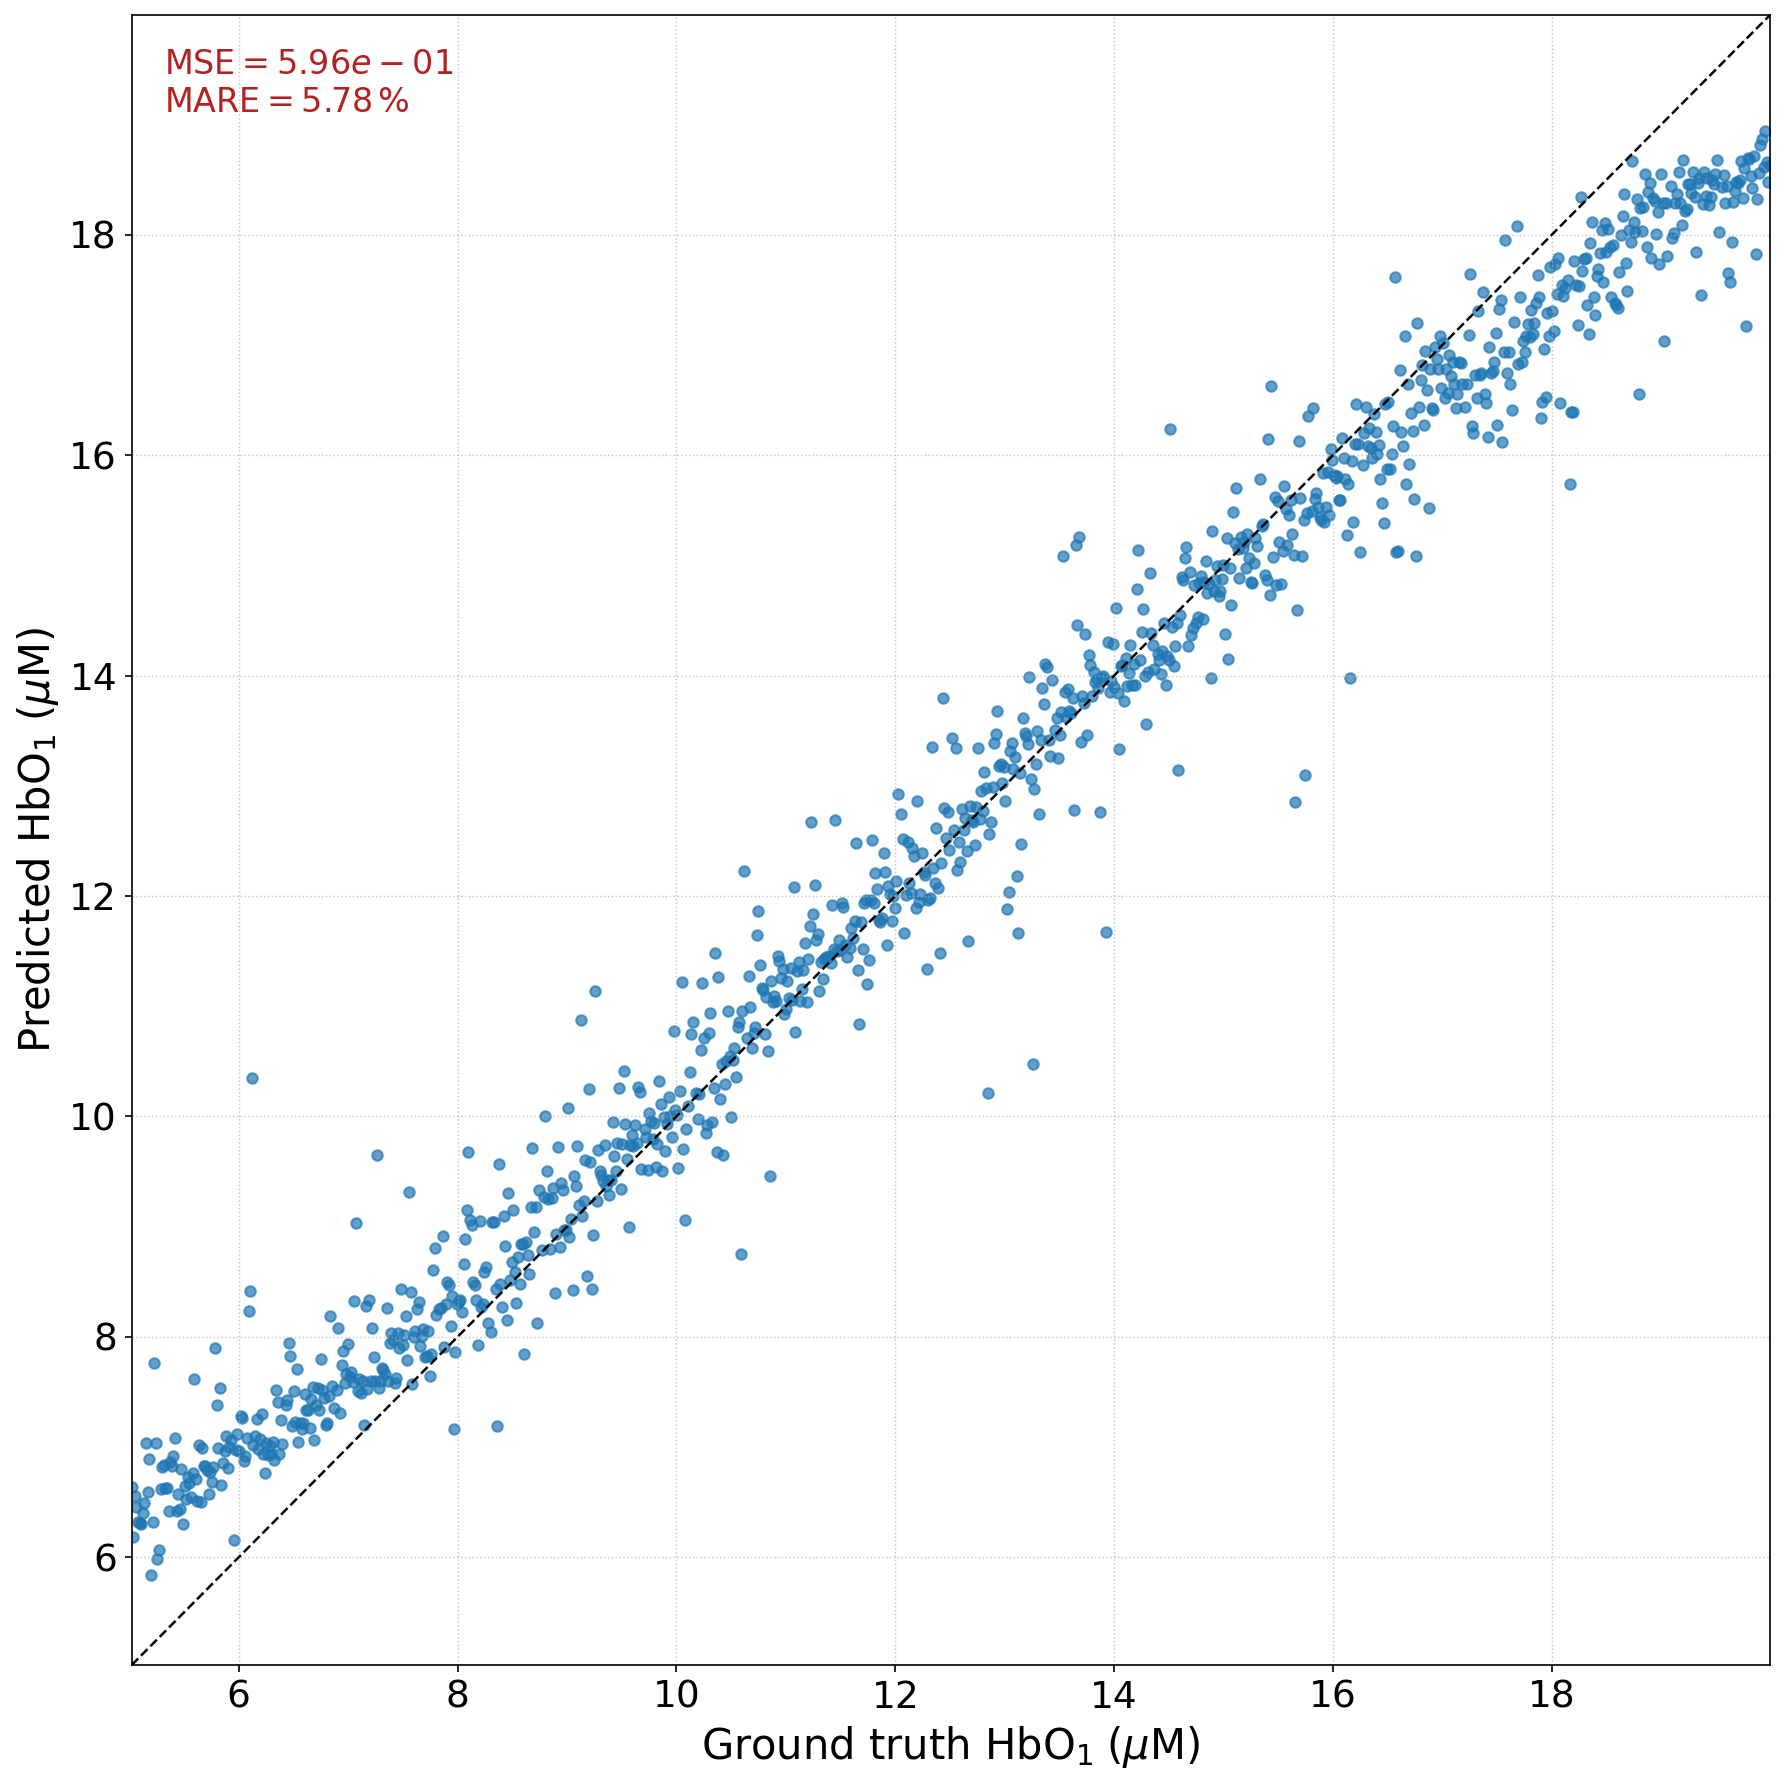

In [21]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ HbO}_{1}\;(\mu\mathrm{M})$",
    y_label=r"$\mathrm{Predicted\ HbO}_{1}\;(\mu\mathrm{M})$"
)
plt.show()

### HHB1

In [22]:
target = 'HHB1'
starget = 'hhb1'
name = 'Hb1'

In [23]:
X_test = load_x()
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files_test = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files_test], ignore_index=True)
sorted_ids = [i+1 for i in range(1000)]
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()
Y = GT_filtered[target].values
y_test = Y.reshape(-1, 1)
scaler_X = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/X_FD_{starget}_ANN.pkl')
scaler_Y = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/Y_FD_{starget}_ANN.pkl')
X_test  = scaler_X.transform(X_test)
Y_test = scaler_Y.transform(y_test)
model = tf.keras.models.load_model(f'/content/drive/MyDrive/MCX_data/weights_fd/FD_{starget}_ANN.keras')
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, scaler_Y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_Y.transform(np.array([[param_ranges[target][1]]]))[0][0])
y_pred = scaler_Y.inverse_transform(y_pred)
y_test = scaler_Y.inverse_transform(Y_test)
mse = mean_squared_error(Y_test, y_pred)
y_pred_Hb1 = y_pred
y_test_Hb1 = y_test

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


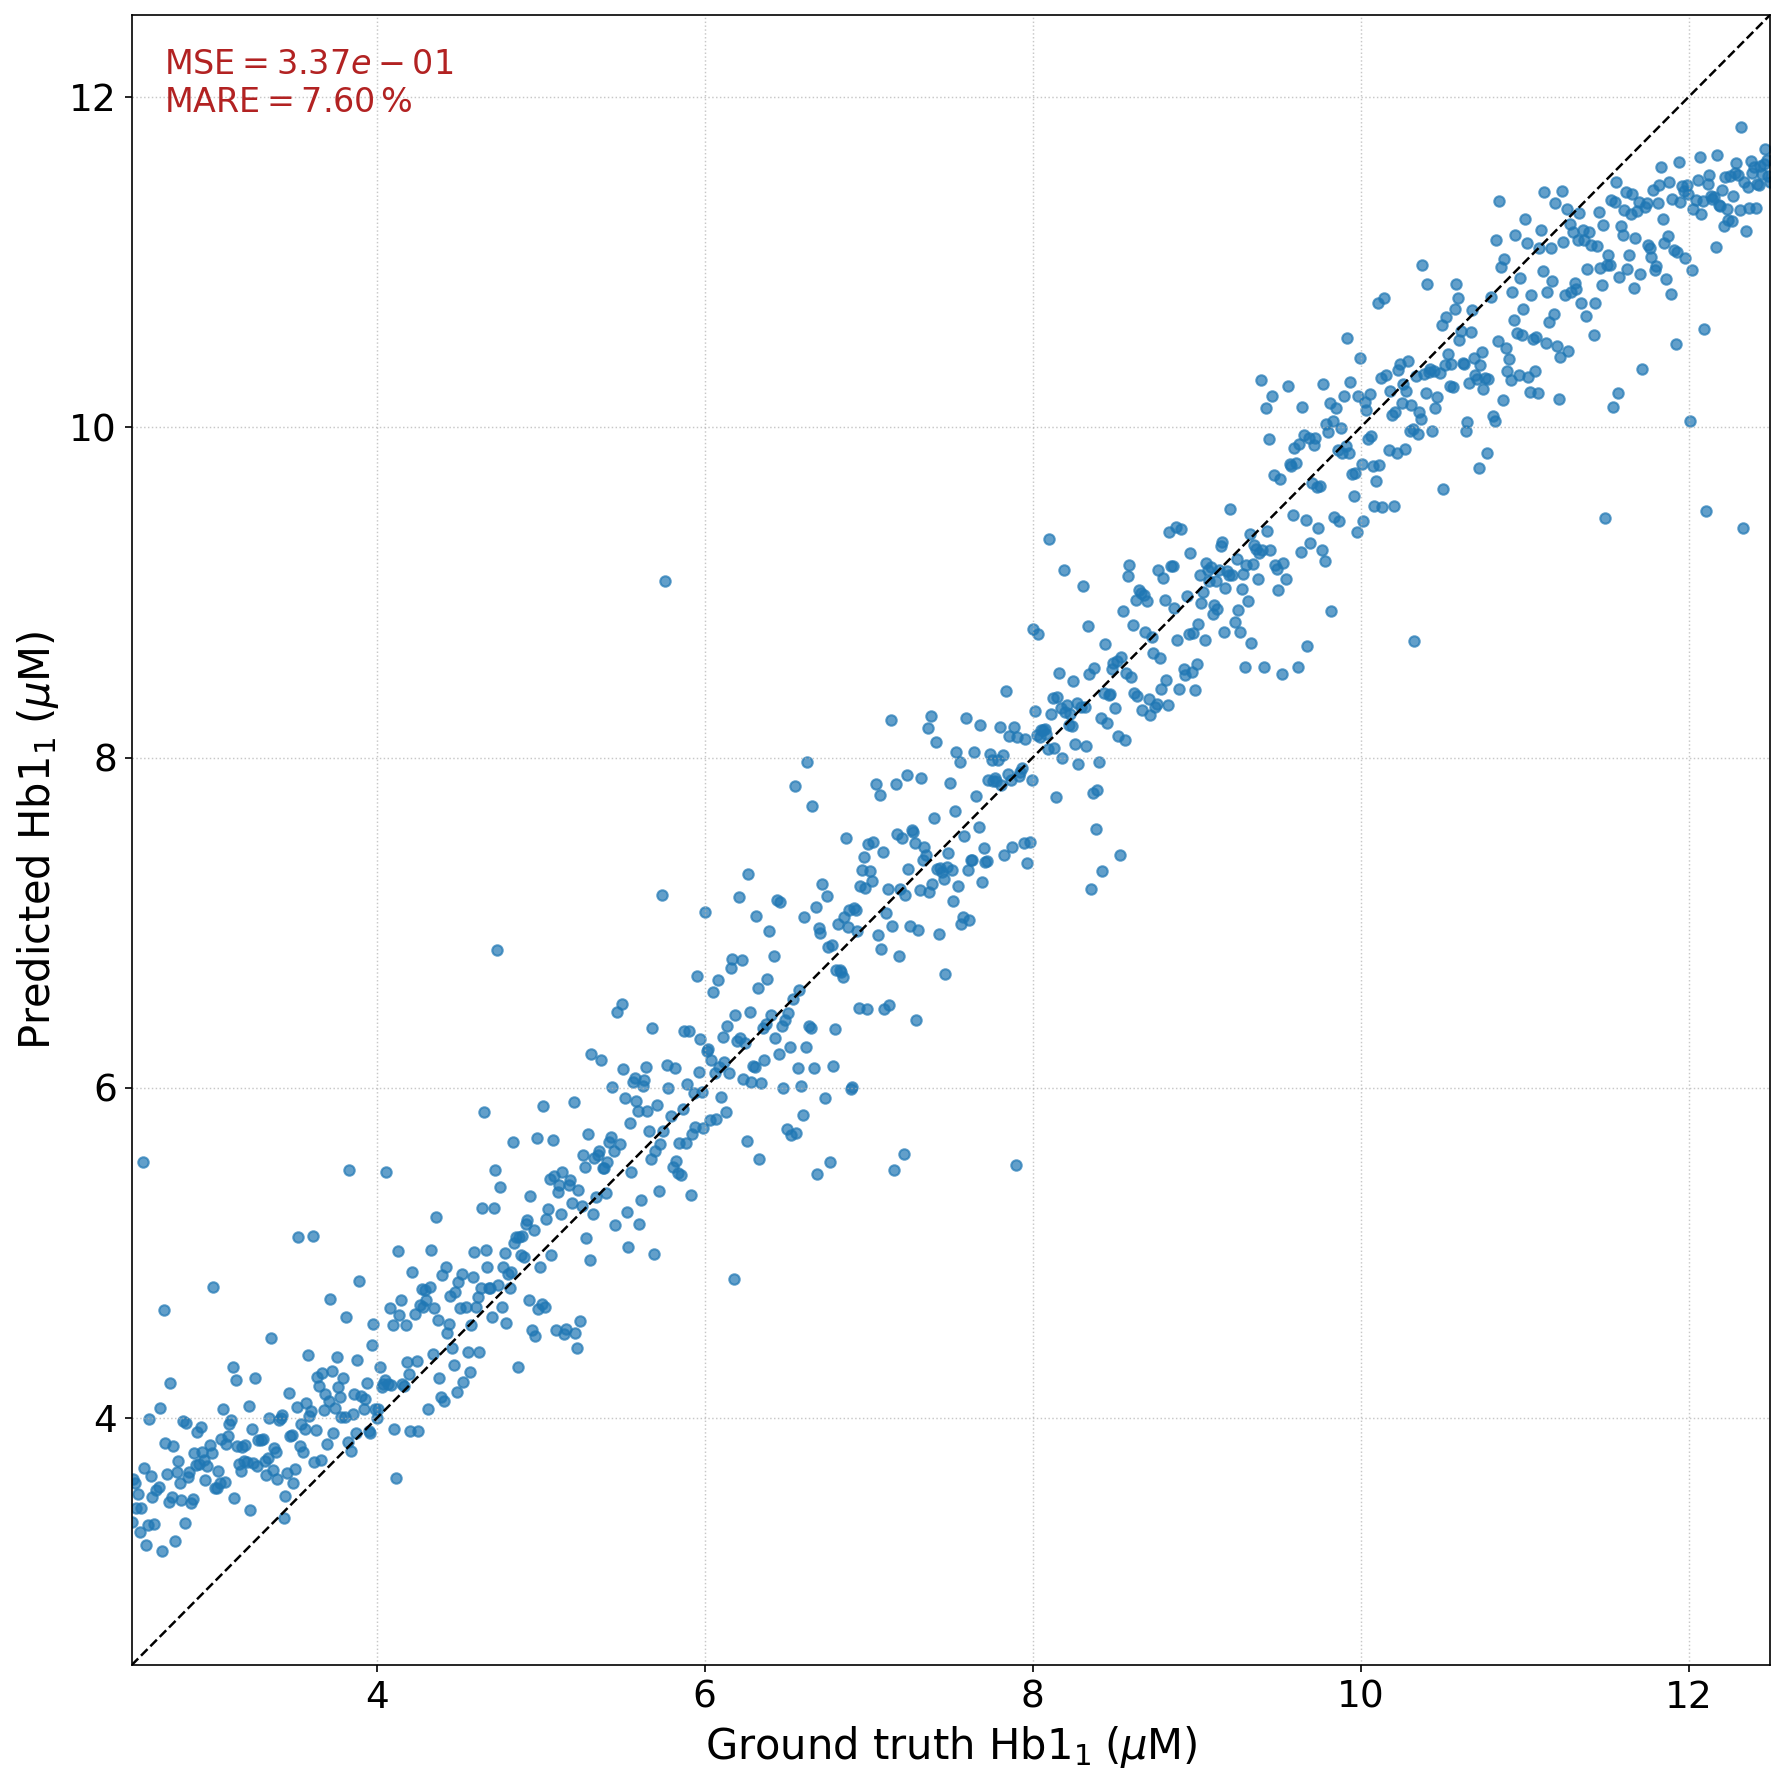

In [24]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ Hb1}_{1}\;(\mu\mathrm{M})$",
    y_label=r"$\mathrm{Predicted\ Hb1}_{1}\;(\mu\mathrm{M})$"
)
plt.show()

### HbO2

In [25]:
target = 'HBO2'
starget = 'hbo2'
name = 'HbO2'

In [26]:
X_test = load_x()
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files_test = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files_test], ignore_index=True)
sorted_ids = [i+1 for i in range(1000)]
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()
Y = GT_filtered[target].values
y_test = Y.reshape(-1, 1)
scaler_X = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/X_FD_{starget}_ANN.pkl')
scaler_Y = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/Y_FD_{starget}_ANN.pkl')
X_test  = scaler_X.transform(X_test)
Y_test = scaler_Y.transform(y_test)
model = tf.keras.models.load_model(f'/content/drive/MyDrive/MCX_data/weights_fd/FD_{starget}_ANN.keras')
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, scaler_Y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_Y.transform(np.array([[param_ranges[target][1]]]))[0][0])
y_pred = scaler_Y.inverse_transform(y_pred)
y_test = scaler_Y.inverse_transform(Y_test)
mse = mean_squared_error(Y_test, y_pred)
y_pred_HbO2 = y_pred
y_test_HbO2 = y_test

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


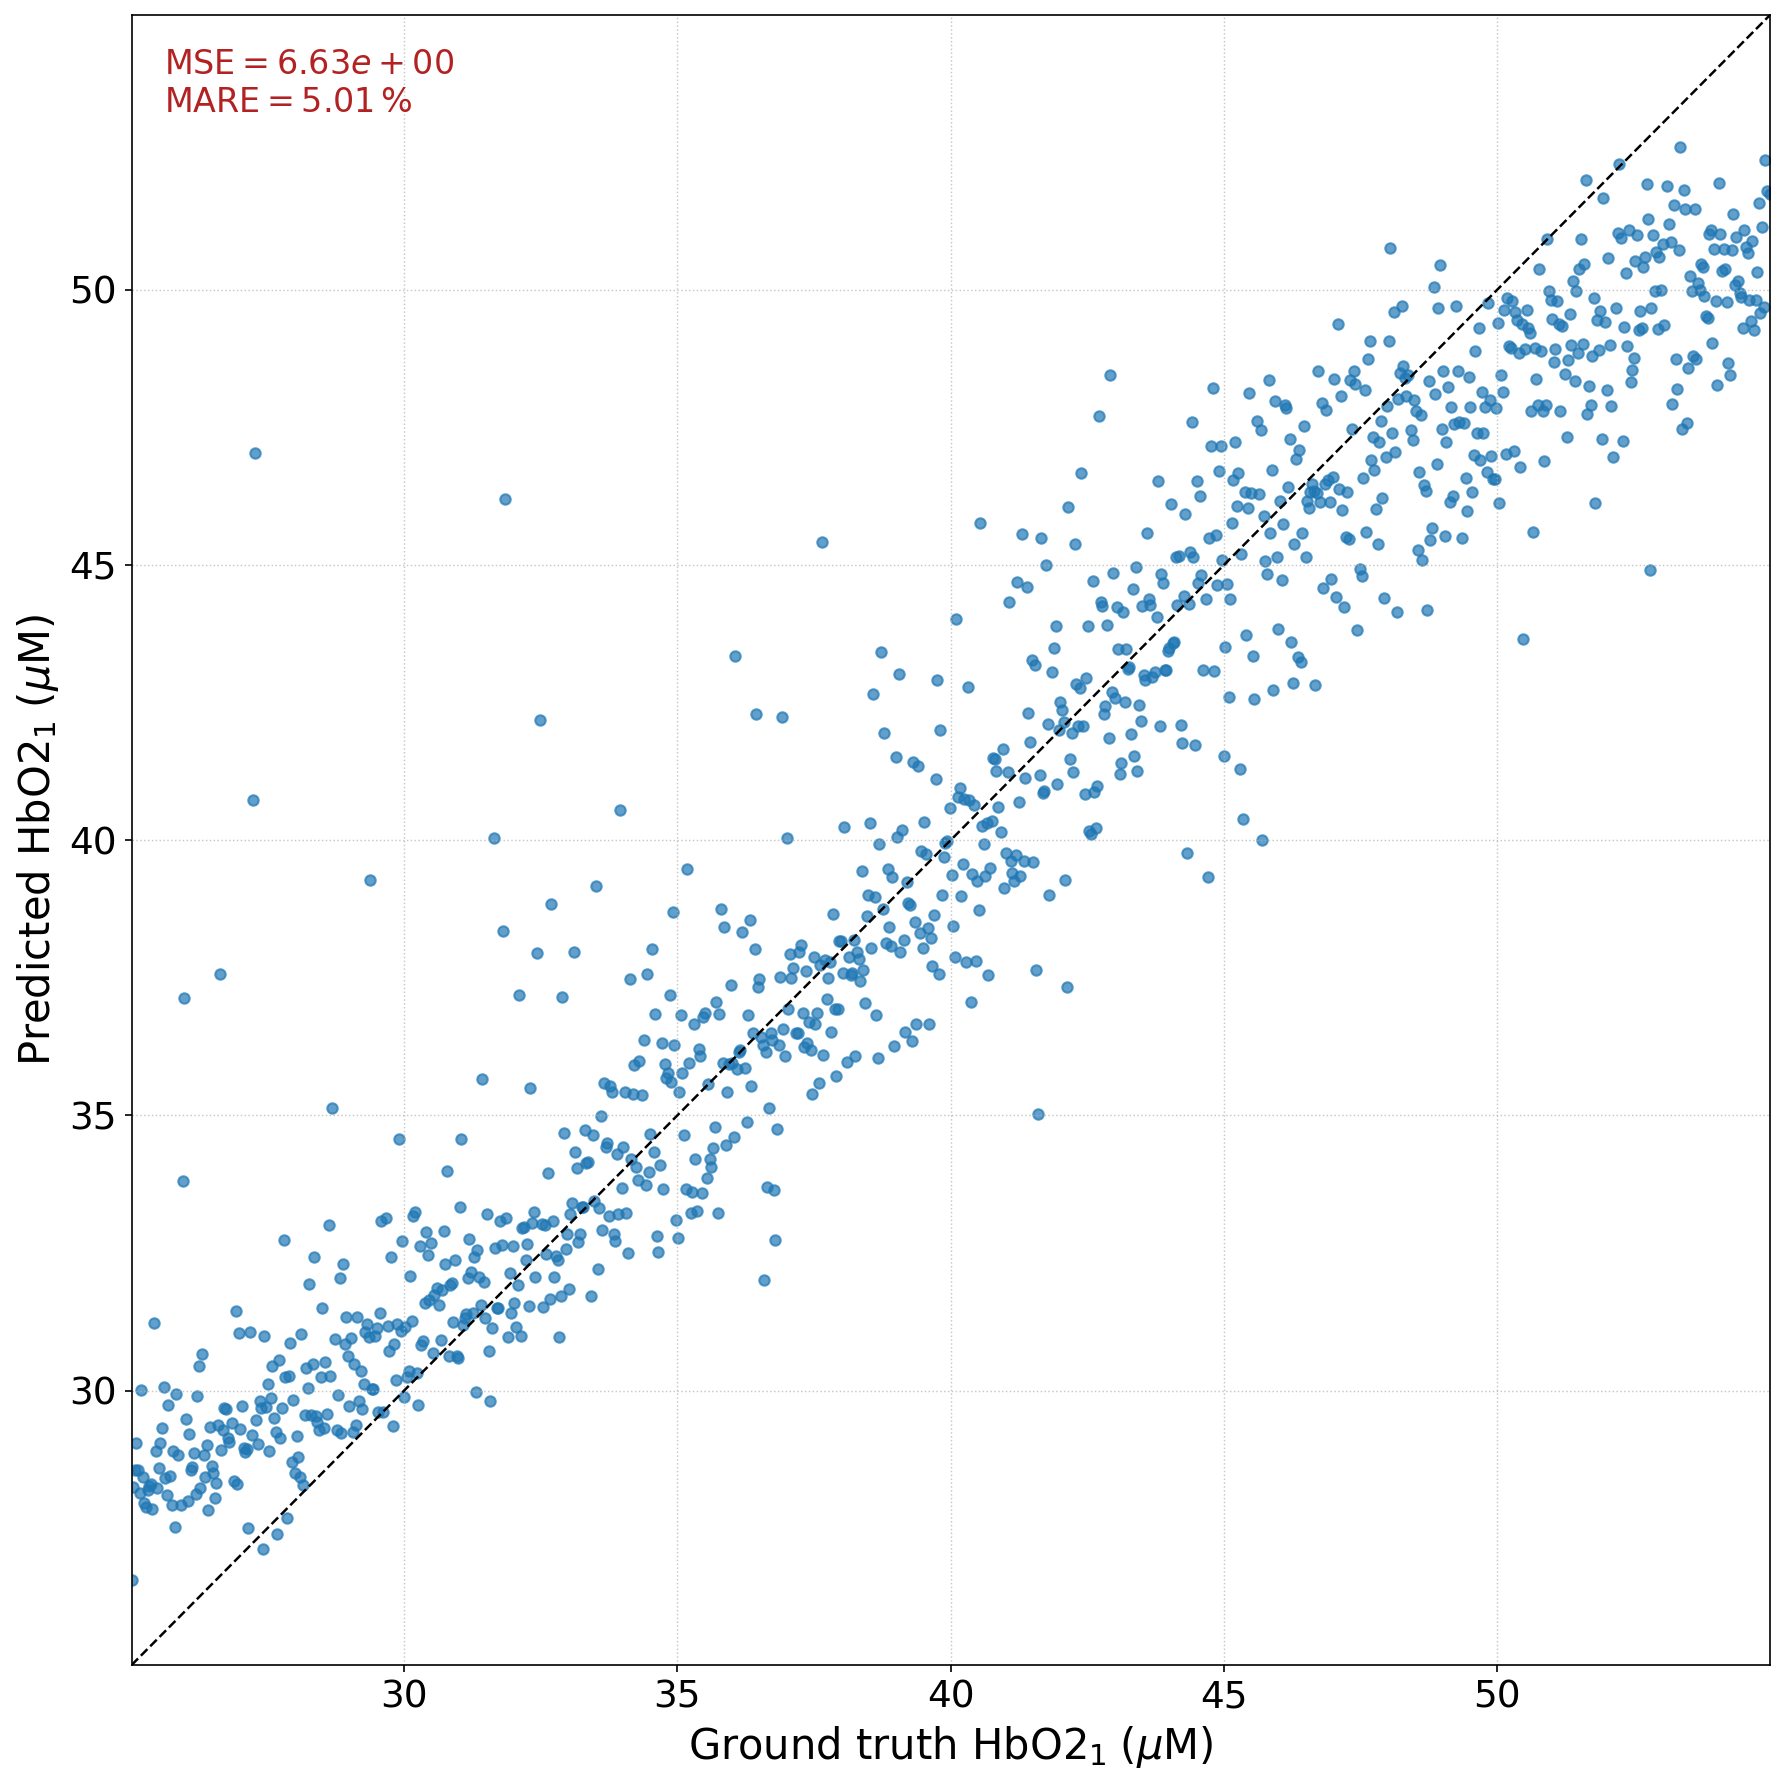

In [27]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ HbO}_{2}\;(\mu\mathrm{M})$",
    y_label=r"$\mathrm{Predicted\ HbO}_{2}\;(\mu\mathrm{M})$"
)
plt.show()

### HHB2

In [28]:
target = 'HHB2'
starget = 'hhb2'
name = 'Hb2'

In [29]:
X_test = load_x()
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files_test = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files_test], ignore_index=True)
sorted_ids = [i+1 for i in range(1000)]
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()
Y = GT_filtered[target].values
y_test = Y.reshape(-1, 1)
scaler_X = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/X_FD_{starget}_ANN.pkl')
scaler_Y = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/Y_FD_{starget}_ANN.pkl')
X_test  = scaler_X.transform(X_test)
Y_test = scaler_Y.transform(y_test)
model = tf.keras.models.load_model(f'/content/drive/MyDrive/MCX_data/weights_fd/FD_{starget}_ANN.keras')
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, scaler_Y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_Y.transform(np.array([[param_ranges[target][1]]]))[0][0])
y_pred = scaler_Y.inverse_transform(y_pred)
y_test = scaler_Y.inverse_transform(Y_test)
mse = mean_squared_error(Y_test, y_pred)
y_pred_Hb2 = y_pred
y_test_Hb2 = y_test

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


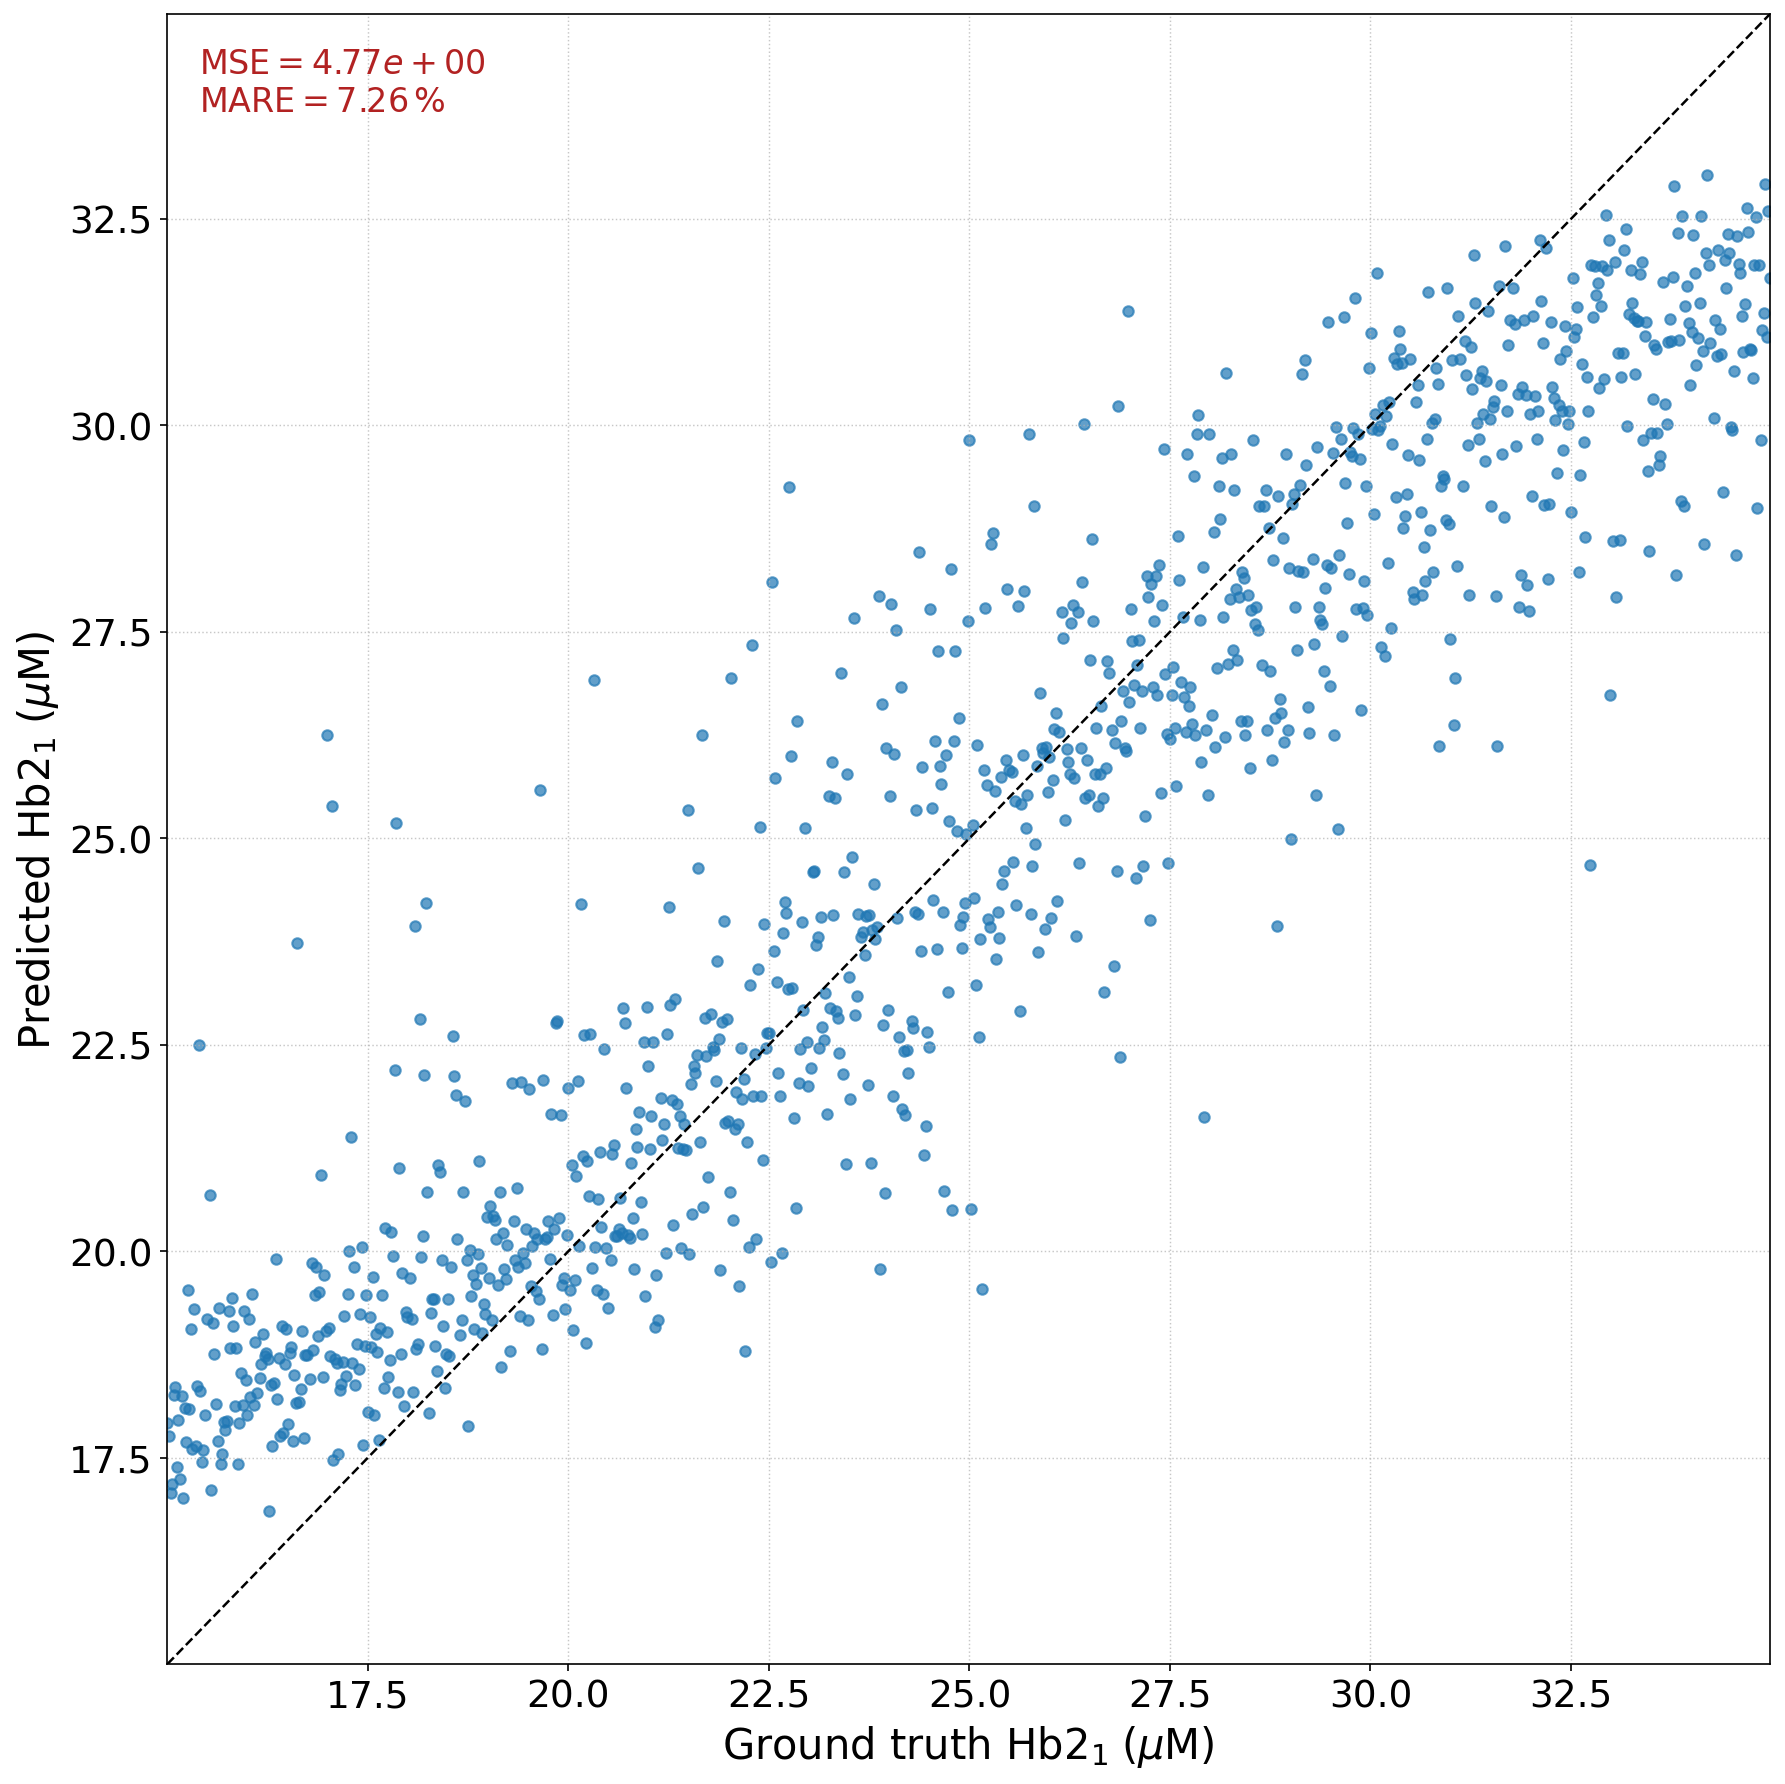

In [30]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ Hb2}_{1}\;(\mu\mathrm{M})$",
    y_label=r"$\mathrm{Predicted\ Hb2}_{1}\;(\mu\mathrm{M})$"
)
plt.show()

### D1

In [33]:
target = 'd1'
starget = 'thickness'
name = 'd1'

In [34]:
X_test = load_x()
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files_test = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files_test], ignore_index=True)
sorted_ids = [i+1 for i in range(1000)]
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()
Y = GT_filtered[target].values
y_test = Y.reshape(-1, 1)
scaler_X = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/X_FD_{target}_ANN.pkl')
scaler_Y = joblib.load(f'/content/drive/MyDrive/MCX_data/weights_fd/Y_FD_{target}_ANN.pkl')
X_test  = scaler_X.transform(X_test)
Y_test = scaler_Y.transform(y_test)
model = tf.keras.models.load_model(f'/content/drive/MyDrive/MCX_data/weights_fd/FD_{target}_ANN.keras')
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, scaler_Y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_Y.transform(np.array([[param_ranges[target][1]]]))[0][0])
y_pred = scaler_Y.inverse_transform(y_pred)
y_test = scaler_Y.inverse_transform(Y_test)
mse = mean_squared_error(Y_test, y_pred)
y_pred_d1 = y_pred
y_test_d1 = y_test

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


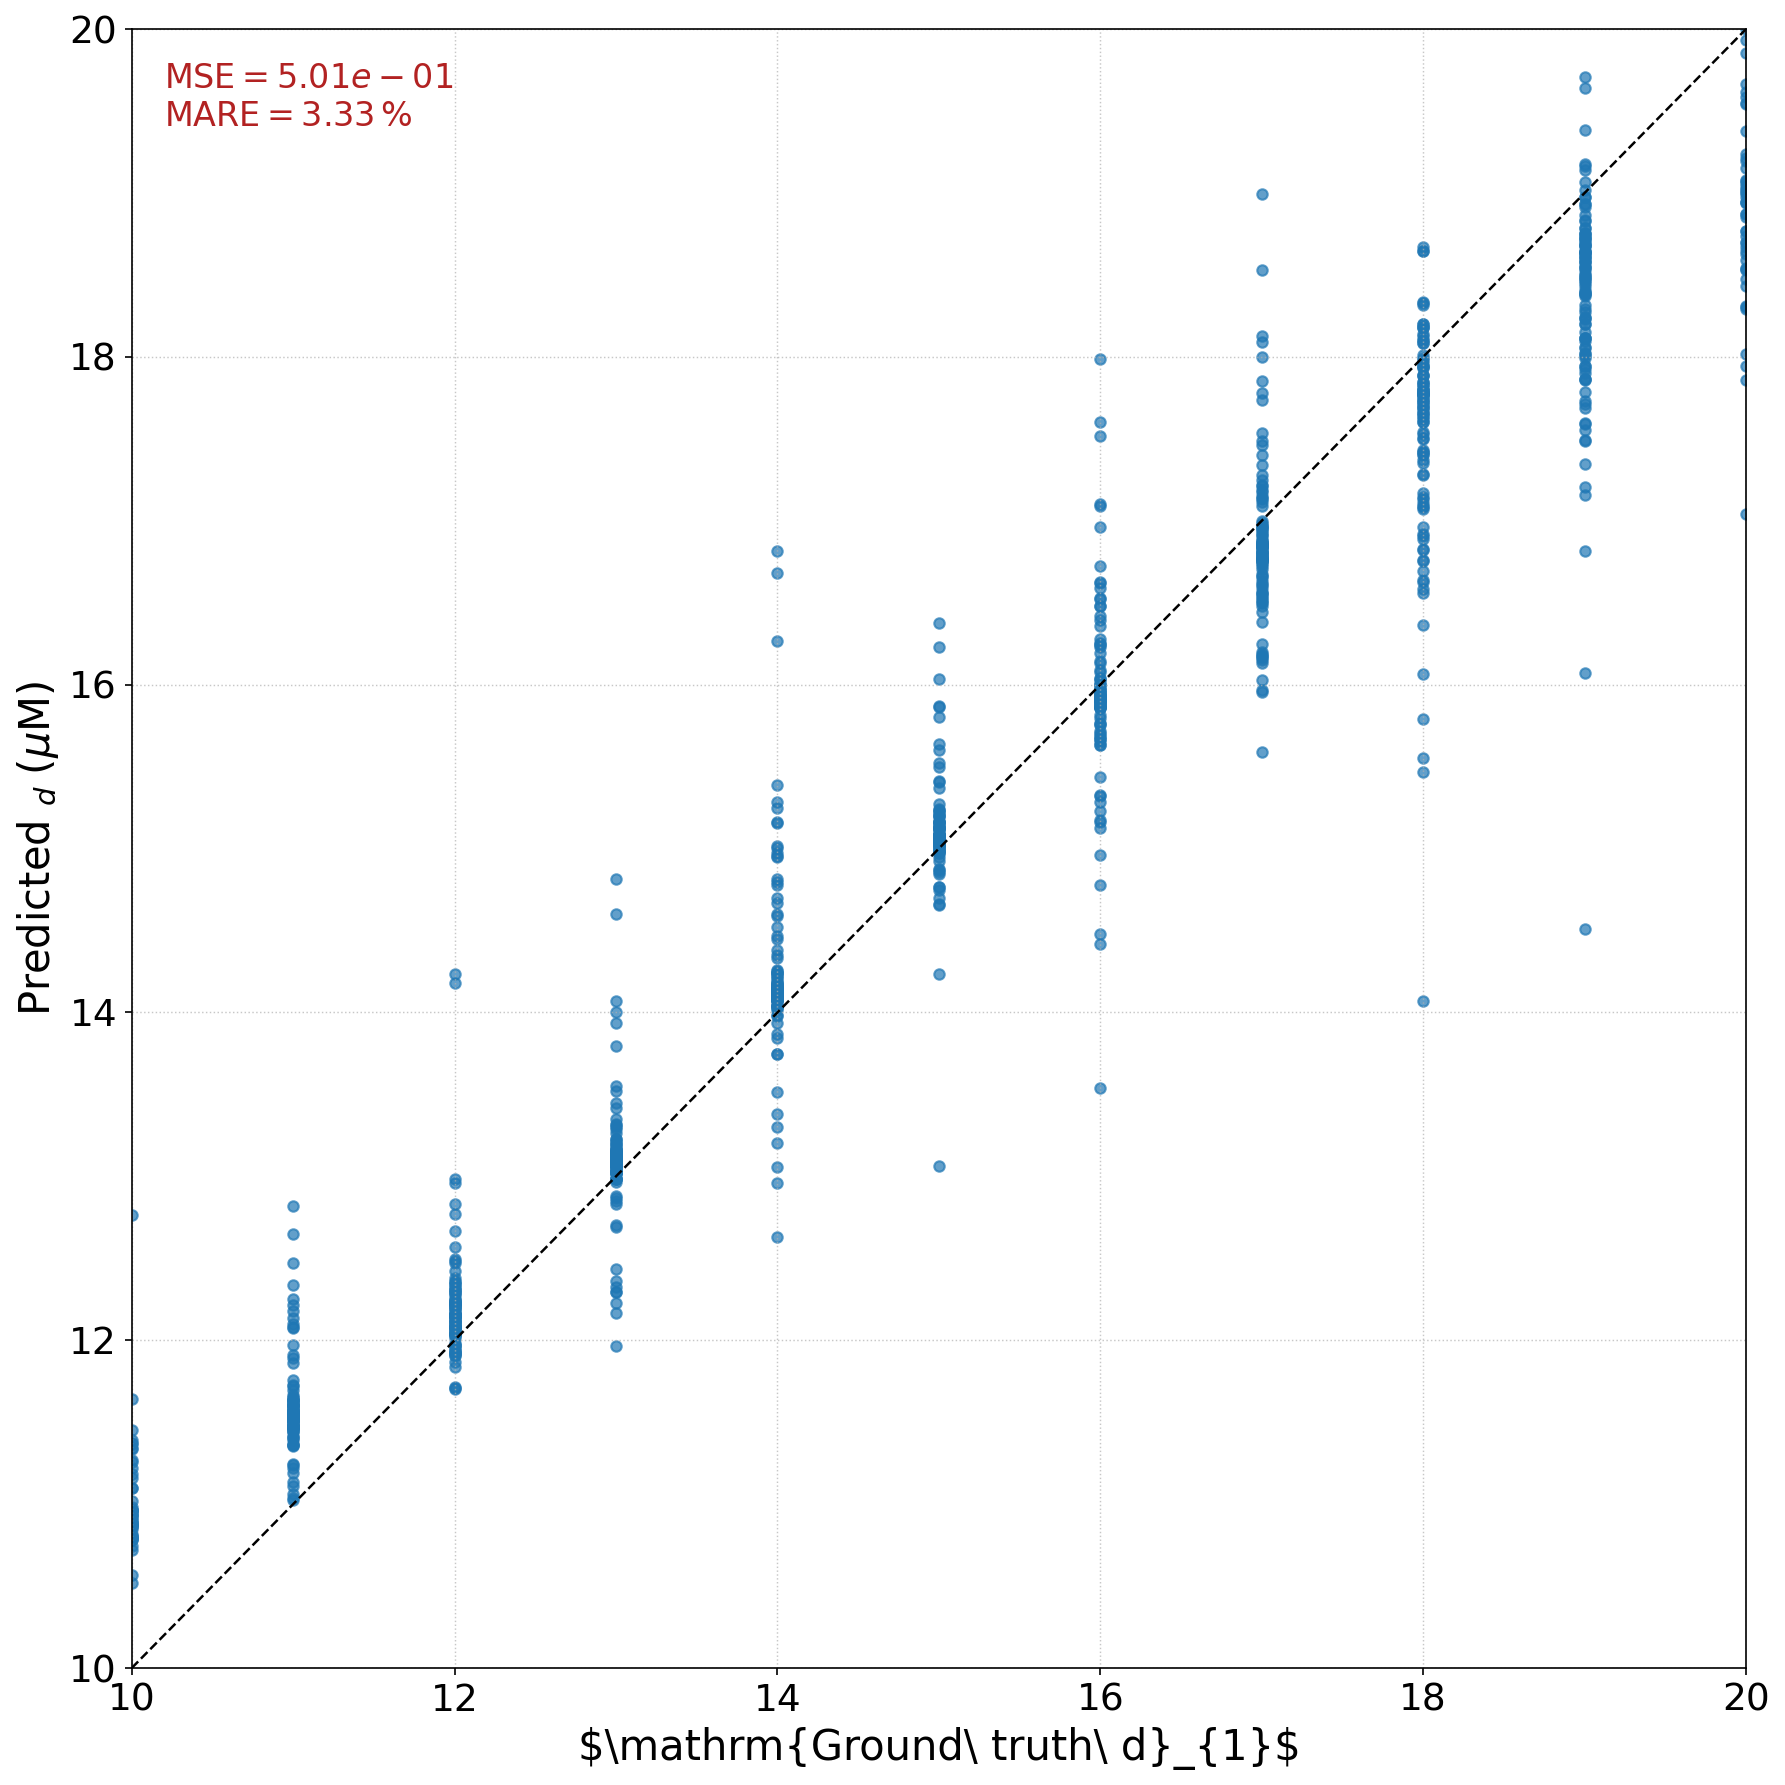

In [35]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ d}_{1}\$",
    y_label=r"$\mathrm{Predicted\ }_d\;(\mu\mathrm{M})$"
)
plt.show()

In [46]:
metrics = regression_metrics(y_test_d1, y_pred_d1, label=starget)

thickness metrics on test set (n = 1000):
  MAE        :  0.4851
  MARE       :  3.33 %
  RMSE       :  0.7081
  R²         :  0.9409
  Bias ± SD  : -0.0105 ±  0.7084


#### Plotings

/tmp/ipython-input-42-1956933351.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


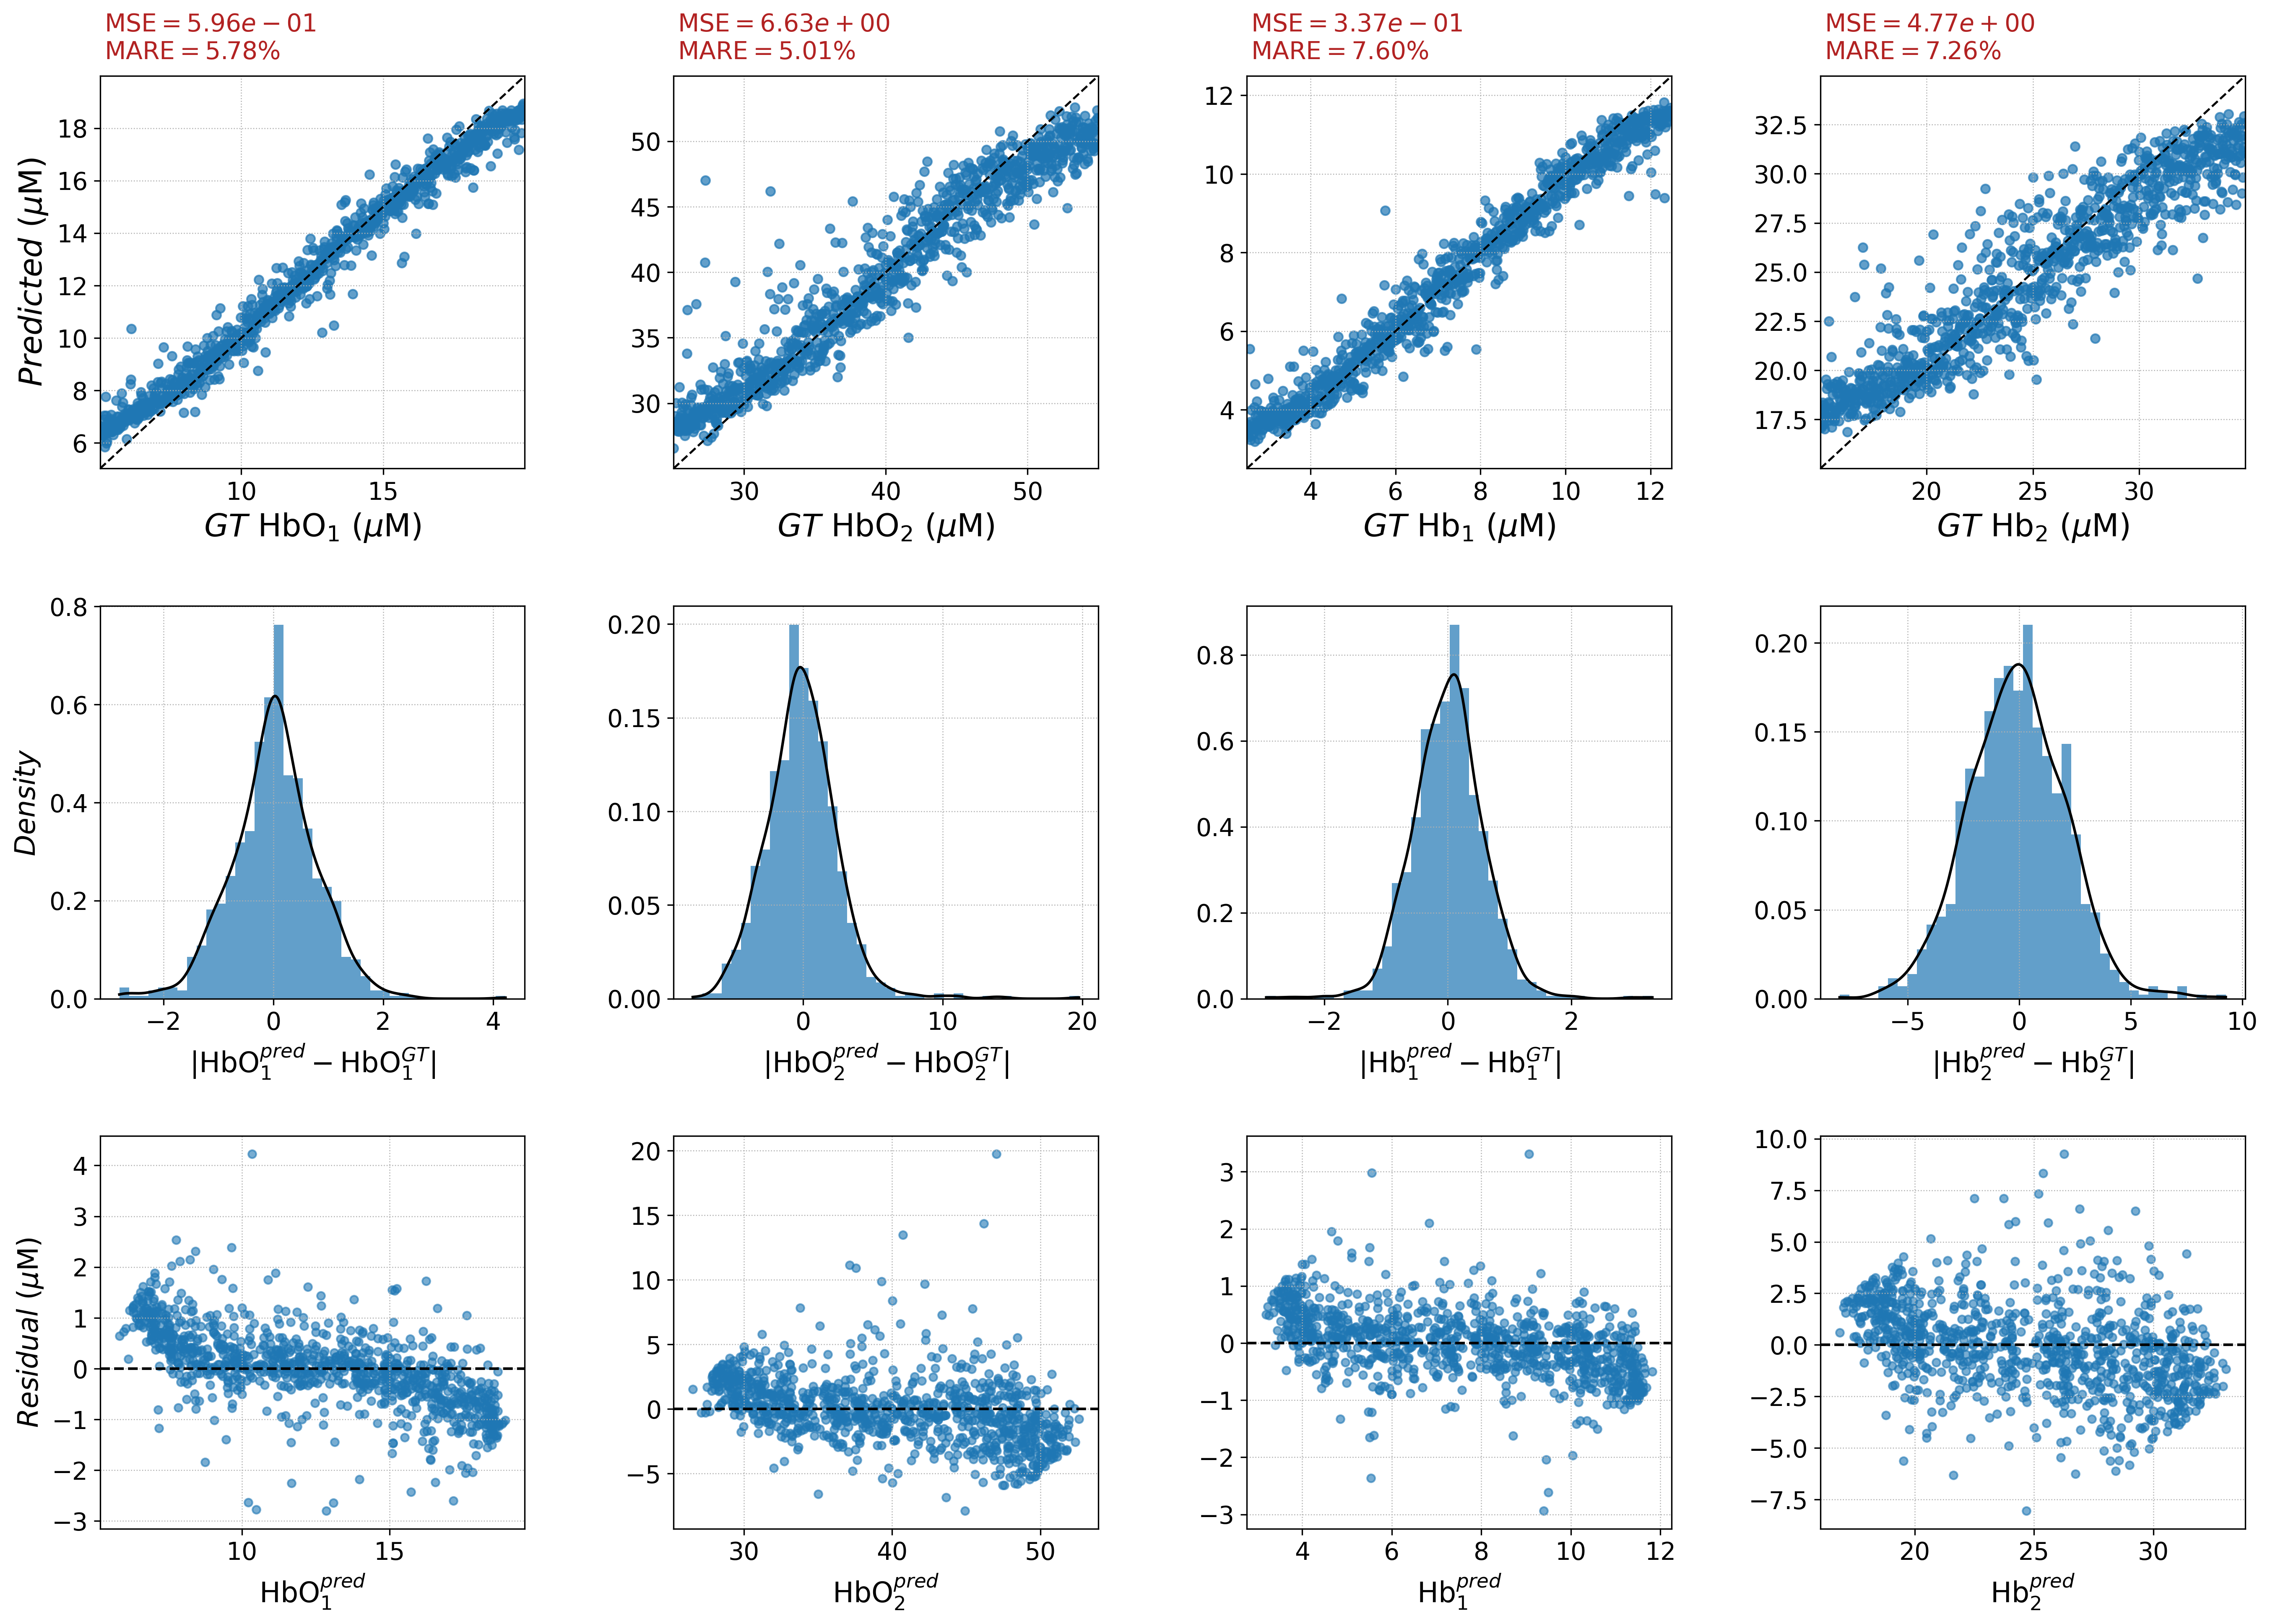

In [43]:
names   = [r"\mathrm{HbO}_{1}", r"\mathrm{HbO}_{2}", r"\mathrm{Hb}_{1}",  r"\mathrm{Hb}_{2}"]

fig = plot_3x4_suite(
        [y_test_HbO1, y_test_HbO2, y_test_Hb1, y_test_Hb2],
        [y_pred_HbO1, y_pred_HbO2, y_pred_Hb1, y_pred_Hb2],
        names,
        units=r"\mu\mathrm{M}",
)
fig.savefig("NIRS_8panel.png", dpi=600, bbox_inches="tight")
plt.show()

In [37]:
names = ["HbO₁", "HbO₂", "Hb₁", "Hb₂"]
df_metrics = metrics_table(
    [y_test_HbO1, y_test_HbO2, y_test_Hb1, y_test_Hb2],
    [y_pred_HbO1, y_pred_HbO2, y_pred_Hb1, y_pred_Hb2],
    names
)

df_metrics.to_csv("metrics.csv", index=False)
print(df_metrics.to_latex(index=False, float_format="%.3f"))

Parameters   MAE  MARE (%)  RMSE  $R^{2}$      Bias ± SD
      HbO₁ 0.582     5.782 0.772    0.968  0.016 ± 0.773
      HbO₂ 1.905     5.014 2.575    0.912 -0.073 ± 2.576
       Hb₁ 0.439     7.604 0.580    0.960  0.005 ± 0.580
       Hb₂ 1.712     7.262 2.185    0.857 -0.121 ± 2.183
\begin{tabular}{lrrrrl}
\toprule
Parameters & MAE & MARE (%) & RMSE & $R^{2}$ & Bias ± SD \\
\midrule
HbO₁ & 0.582 & 5.782 & 0.772 & 0.968 & 0.016 ± 0.773 \\
HbO₂ & 1.905 & 5.014 & 2.575 & 0.912 & -0.073 ± 2.576 \\
Hb₁ & 0.439 & 7.604 & 0.580 & 0.960 & 0.005 ± 0.580 \\
Hb₂ & 1.712 & 7.262 & 2.185 & 0.857 & -0.121 ± 2.183 \\
\bottomrule
\end{tabular}



/tmp/ipython-input-44-3252712579.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.07, 1, 1])


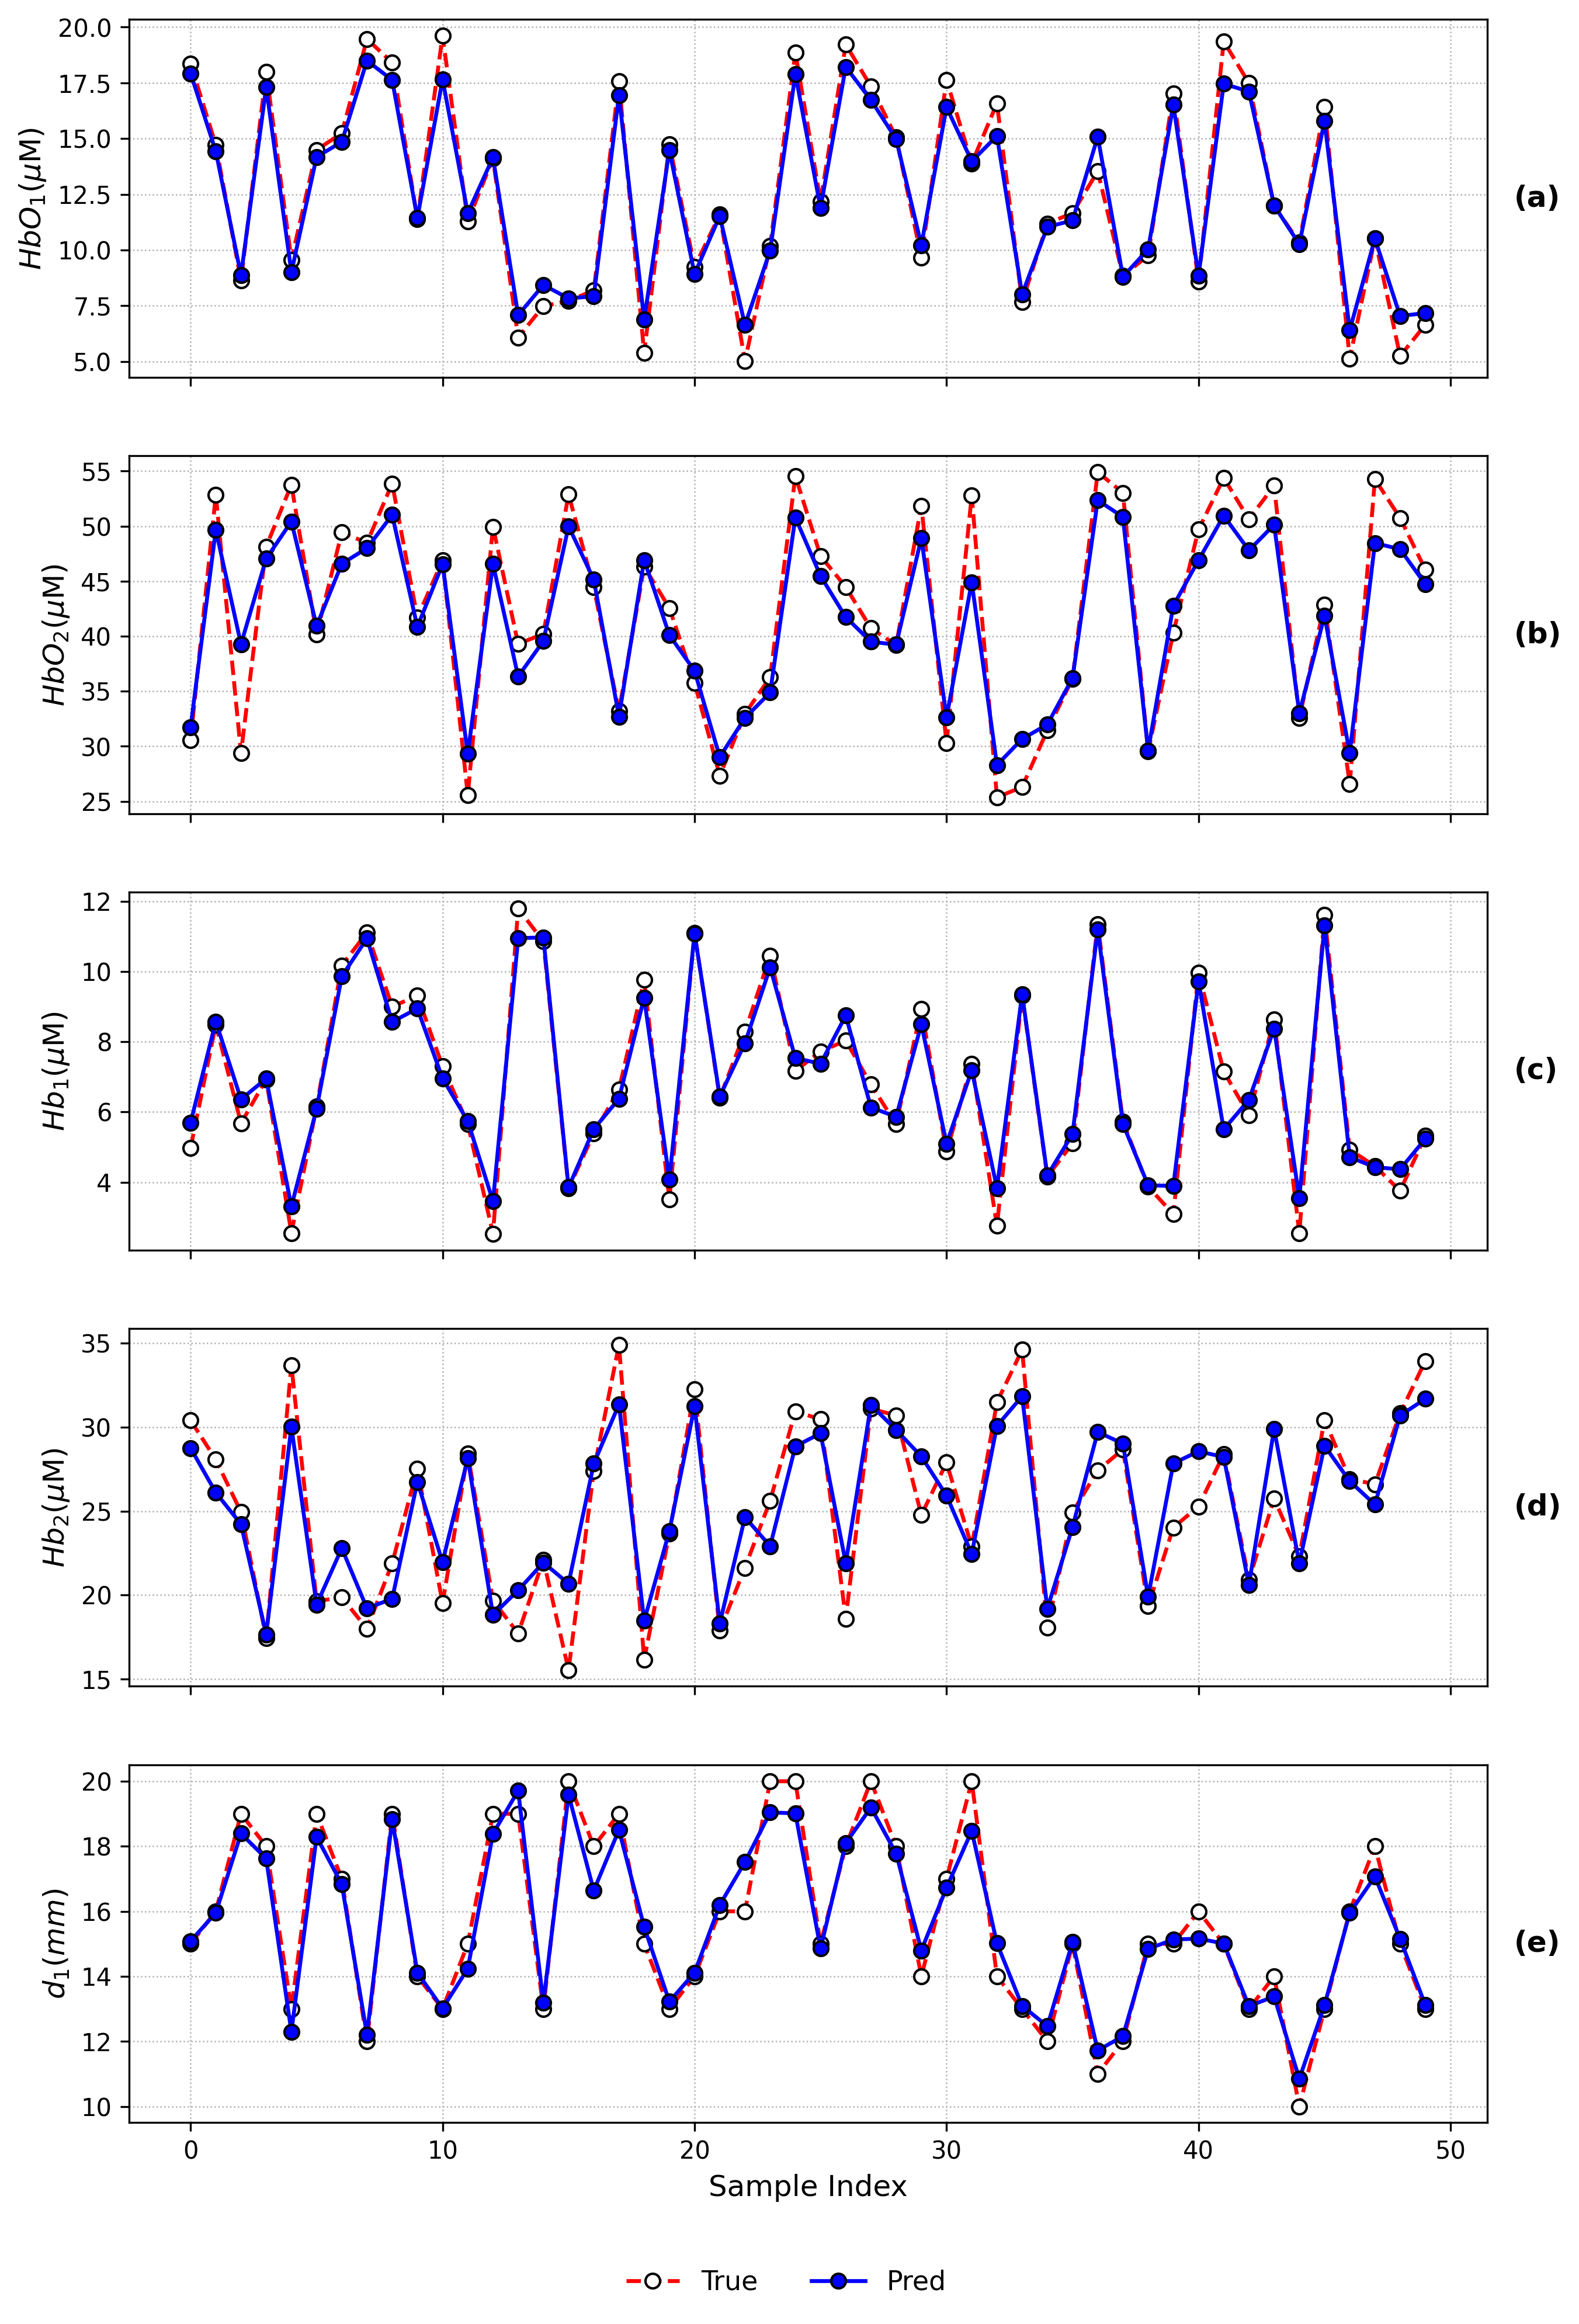

In [45]:
fig = plot_random_sequences(
        y_trues=[y_test_HbO1, y_test_HbO2, y_test_Hb1, y_test_Hb2, y_test_d1],
        y_preds=[y_pred_HbO1, y_pred_HbO2, y_pred_Hb1, y_pred_Hb2, y_pred_d1],
        names=[r"HbO_{1} (\mu\mathrm{M})", r"HbO_{2} (\mu\mathrm{M})", r"Hb_{1} (\mu\mathrm{M})", r"Hb_{2} (\mu\mathrm{M})", r"d_{1} (mm)"],
        n_samples=50,
        random_state=42
)

fig.savefig("random_stacked_four.png", dpi=600, bbox_inches="tight")
plt.show()
